# Topic 2 - How do we compare DNA sequences?
## Dynamic Programming
Material and embedded lab.

Motivation and some exercises are variations on those available in Bioinformatics Algorithms: An Active-Learning Approach by Phillip Compeau & Pavel Pevzner.

In [2]:
%load_ext autoreload
%autoreload 2


# Put all your solutions into Lab1_helper.py as this script which is autograded
import Topic2_helper 

from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. 
# This is not relevant to most people because I recommended you use my server, but
# change home to where you are storing everything. Again. Not recommended.

Data frames/signatures/etc - you may immediately translate the pandas structures that I uses into your own Python generic data structures. I find this to make the problems harder, but this could make the problems easier for you. It is up to you :) You must satisfy the autograder of course so don't change the input or output types.

Learning objectives for the week and lab:
1. Build our mental model of biology by incorporating comparison as a framework for understanding biology
2. Apply your dynamic programming experience from algorithms
3. Gain experience translating a biological problem into a problem we can solve via code

# History and motivation

Searching all new sequences against sequence databases is now the first order of business in genomics!

Why is it so important to us?

### Detour: Central Dogma

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Extended_Central_Dogma_with_Enzymes.jpg/550px-Extended_Central_Dogma_with_Enzymes.jpg" width=800>

### Detour: Ribosome

Ribosomes are macromolecular machines, found within all living cells, that perform biological protein synthesis (translation).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Peptide_syn.svg/2560px-Peptide_syn.svg.png" width=600>

## Mohamed Marahiel

Marahiel conjectured that since A-domains of proteins (adenylation domains) have the same function (i.e., adding an amino acid to the growing peptide), different A-domains should have similar parts. 

Each A-domain is about 500 amino acids long and is responsible for adding a single amino acid.

Taking 3 common A-domains and putting them down one after another, there are only three conserved columns (shown in red below) are common to the three sequences and have likely arisen by pure chance:

<img src="http://bioinformaticsalgorithms.com/images/Alignment/A_domain_2.png" width=2000>

Well that stinks...

If we slide the second sequence only one amino acid to the right, adding a space symbol ("-") to the beginning of the sequence, then we find 11 conserved columns!

<img src="http://bioinformaticsalgorithms.com/images/Alignment/A_domain_3.png" width=2000>

Adding a few more space symbols reveals 14 conserved columns:

<img src="http://bioinformaticsalgorithms.com/images/Alignment/A_domain_4.png" width=2000>

Now that is getting better, and the number of conserved columns is going up!

### Detour: Non-ribosomal code

The nonribosomal code refers to key amino acid residues and position in an adenylation domain of a nonribosomal peptide (sequence of amino acids).

This code is used to predict substrate specificity and thus (partially) the final product.

i.e., this sequence is important.

It turns out that the red columns represent the conserved core shared by many A-domains. Now that Marahiel knew how to correctly align the A-domains, he discovered that the non-ribosomal code is defined by 8 amino acid-long non-ribosomal signatures, which are shown as purple columns below.

<img src="http://bioinformaticsalgorithms.com/images/Alignment/A_domain_6.png" width=2000>

## Quick aside about the book chapter

So the book has a very interesting introduction to this topic, but I would say that it requires more biology than currently within reach of this class in a single pass (i.e., one week). We will be layering in some of this biology this week and we'll build on it throughout the semester.

## Identification of homologous genes
* Two genes are homologous if they share a common ancestor
* Living organisms share a large number of genes descended from common ancestors 
* Functionality is preserved but differences in sequence accumulate as they diverge from each other. 
* These differences may be due to mutations that change a symbol (nucleotide or amino acid) for another or insertions / deletions, indels, which insert or delete a symbol in the corresponding sequence.

## Our life this topic/lecture

<img src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/book/fundamentals/images/alignment.png" width=500>

## An important distinction (and a biologist will correct you every time)
* Homology is a dichotomous characteristic, i.e., given two genes are either homologous genes or not. It is binary.

* However, given two sequences corresponding to two genes, can be said that there are different levels of similarity based on an alignment between them. 
* Our key question is to determine whether a good alignment between two sequences is significant enough to consider that both genes are homologous. 
    * This task is done through a hypothesis testing and the corresponding p-values are used to make a decision.

## Two different forms of homology. 
Paralogs - When the origin of two homologous genes is due to a process of gene duplication within the same species

Orthologous genes - origin is due to a speciation process resulting in homologous genes in these different species

# Introduction to Sequence Alignment
How do you align/match up ATGCTTA and TGCATTAA that have subtle similarities?
<pre>
ATGC-TTA-
-TGCATTAA
</pre>

It's all a game. The goal is to maximize "points" which for us is matching nucleotides or amino acids.

At each turn, you have two choices
1. You can remove the first symbol from both sequences and align them. You'll earn a point if they match.
2. You can remove the first symbol from either of the two sequences in which case you earn no points, but you may set yourself up to earn more points later. 

**Note:** We are going to introduce some simple greedy approaches that are not optimal in any sense, but they provide a good way to introduce some of the mechanics here.

### Greedy approach
Let's say that we want to take a greedy approach to alignment. Meaning we will only consider the choice in front of us. Example:

<pre>
s1=AACCTTGG
s2=ACACTGTGA
</pre>

For each move in the game (ix1=ix2=0): 
* if s1[ix1] == s2[ix2], then add s1[ix2] to the longest common subsequence and increment ix1 and ix2
* elif len(s1)-ix1 > len(s2)-ix2, then assume there is a gap in s2 since it is shorter and  increment ix1
* elif len(s2)-ix2 > len(s1)-ix1, then assume there is a gap in s1 since it is shorter and increment ix2
* otherwise assume this is a mismatch and increment ix1 and ix2

**Exercise 1** Use a greedy approach to return suboptimal (or by chance an optimal) solution to the longest common subsequence problem.

Find a longest common subsequence of two strings

Input: Two strings

Output: A longest common subsequence of these strings

In [3]:

print(Topic2_helper.greedy_lcs("AACCTTGG","ACACTGTGA"))

print(Topic2_helper.greedy_lcs("AACCTTGG","ACAC"))

AACTG
AC


Well... That was easy to implement, but the longest common subsequence is AACTGG, so we did not really solve the problem. Before we move on though, let's modify our algorithm so it returns the alignment (i.e., with indels and mutations).

**Exercise 2** Modify your solution to exercise 1 to return the alignment as two strings with "-" characters when there is a indel. Do not modify ``random_action`` as that is what the autograder is going to rely on you using. HINT: Just keep track of the strings before calling ``random_action``.

In [4]:

print(Topic2_helper.greedy_alignment("AACCTTGG","ACACTGTGA"))
print()
print(Topic2_helper.greedy_alignment("AACCTTGG","ACAC"))

A-ACCTTGG
ACACTGTGA

AACCTTGG
A-C---AC


## Why do we have mismatches in our alignment? Why not just gaps?
When consider both nucleotide sequences and amino acid sequences (different alphabets if you are a pure CS thinker), then sometimes you can achieve a better overall alignment if you allow for mismatches. In fact, some mismatches are actually neutral in certain ways when you consider their impact on the organism and its biology.

**But how do we find the optimal solution which is by definition the longest common subsequence?** Let's not worry about that for a moment and remind ourselves of dynamic programming and recurrance relations.

This is a good time to watch the video by Dr. Davidson: <a href="https://calpoly.zoom.us/rec/play/hBXW5q4PtZy3kYcX6V_Uh8hKyeh3Y2Juo2UVlNnINYrEOPr2B3eA8nw4thx8dmKc1Olp3rOuZj9g5yOo.kzObI8yIb3CvB-AY?startTime=1633451337000&_x_zm_rtaid=bQcfpnQASSqA5m-pwUWcPA.1633475641251.31fa1bec4ed96897fe3c7dc2c9f5cad1&_x_zm_rhtaid=658">The Bio of Bioinformatics</a>

# An Introduction to Dynamic Programming: The Change Problem

**Change Problem:** Find the minimum number of coins needed to make change.

Input: An integer ``money`` and an array ``coins`` of $d$ positive integers.

Output: The minimum number of coins with denominations ``coins`` that changes ``money``.

Consider the problem to change 76 cents in a country with only three denominations: ``coins=[6,5,1]``. A minimal colection of coins totaling 76 cents must be one of the following:
* a minimal collection of coins totaling 75 cents, plus a 1-cent coin
* a minimal collection of coins totaling 71 cents, plust a 5-cent coin
* a minimal collection of coins totaling 70 cents, plus a 6-cent coin

This illustrates a nice recurrence relation for us:
$$
\mbox{MinNumCoins}(money) = min
\left\{
    \begin{array}{l}
      \mbox{MinNumCoins}(money-coin_1) + 1\\
      \mbox{...}\\
      \mbox{MinNumCoins}(money-coin_d)+1
    \end{array}
  \right\}
$$

**Exercise 3** Solve the change problem using the recurance relation given above.

Input: An integer ``money`` and an array ``coins`` of $d$ positive integers.

Output: The minimum number of coins with denominations ``coins`` that changes ``money``.

In [6]:

Topic2_helper.min_num_coins(27,[6,5,1])

5

## Let's time some results

In [11]:
%%timeit
Topic2_helper.min_num_coins(13,[6,5,1])

29.4 µs ± 35.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%%timeit
Topic2_helper.min_num_coins(27,[6,5,1])

3.95 ms ± 9.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
Topic2_helper.min_num_coins(35,[6,5,1])

66.1 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
Topic2_helper.min_num_coins(47,[6,5,1])

4.34 s ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That escalated quickly!

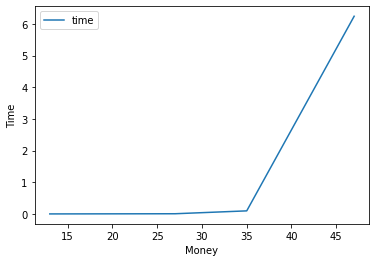

In [15]:
%matplotlib inline
import pandas as pd
ax=pd.DataFrame({"money":[13,27,35,47],"time":[43.2e-6,5.59e-3,96.3e-3,6.24]}).plot.line(x="money",y="time")
ax.set_xlabel('Money')
ax.set_ylabel('Time');

## Is this efficient?
Well. Of course not. It recomputes solutions to subproblems over and over again. We will solve this problem using dynamic programming. 

The book takes a practical approach to dynamic programming, but I would suggest everyone read this section at least on Dynamic programming (https://en.wikipedia.org/wiki/Dynamic_programming#Computer_programming). 

## Bottom-up approach to coins problem
Let's say you knew the following solution to the coins problem for money $\le$ 12:

In [ ]:
pd.DataFrame({"MinNumCoins(money)":[0,1,2,3,1,1,2,3,2,2,2,3,3]},index=pd.Index([0,1,2,3,4,5,6,7,8,9,10,11,12],name="money")).T

Could you easily compute MinNumCoins(13)? What about MinNumCoins(14)? Let's consider MinNumCoins(13). You only have three potential coins you could add at any given time: [6,5,1]. 
* You could try to add in a 6, which would mean that MinNumCoins(13) = MinNumCoins(13-6)+1 = MinNumCoins(7)+1 = 4. 
    * We subtract the 6 because we need to identify the optimal solution to the subproblem we need to examine. 
* We next try 5: MinNumCoins(13) = MinNumCoins(13-5)+1 = MinNumCoins(8)+1 = 3, which is our best solution so far.
* We next try 1: MinNumCoins(13) = MinNumCoins(13-1)+1 = MinNumCoins(12)+1 = 4, which isn't as good.
* We don't have anything else to try, so we know our answer is 3!
* No recursion, and a simple thing to code up.

**Exercise 4** Solve the change problem using a bottom-up dynamic programming strategy.

Input: An integer ``money`` and an array ``coins`` of $d$ positive integers.

Output: The minimum number of coins with denominations ``coins`` that changes ``money``.

In [16]:

Topic2_helper.min_num_coins_dynamic(27,[6,5,1])

5

Much better runtime!

In [17]:
%%timeit
Topic2_helper.min_num_coins_dynamic(47,[6,5,1])

18.6 µs ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Back to sequence alignment
What is our recurence relation? Think top down. Remember our greedy actions that were available. We still only have those options available to us. For clarity, I've put our choices into a dataframe with some additional information including the part that would be added to the alignment for s1 and s2. The final column is the score that would be added to the total score.

In [18]:
s1 = "ACGT"
s2 = "AGCTA"
choices_df = pd.DataFrame({"remainder(s1)":[s1[1:],s1[1:],s1],
              "remainder(s2)":[s2[1:],s2,s2[1:]],
              "s1_part":[s1[0],s1[0],"-"],
              "s2_part":[s2[0],"-",s2[0]],
              "score(s1_part,s2_part)":[int(s1[0]==s2[0]),0,0]})
choices_df

,remainder(s1),remainder(s2),s1_part,s2_part,"score(s1_part,s2_part)"
0,CGT,GCTA,A,A,1
1,CGT,AGCTA,A,-,0
2,ACGT,GCTA,-,A,0


In [19]:
s1 = "GCGT"
s2 = "AGCTA"
choices_df = pd.DataFrame({"remainder(s1)":[s1[1:],s1[1:],s1],
              "remainder(s2)":[s2[1:],s2,s2[1:]],
              "s1_part":[s1[0],s1[0],"-"],
              "s2_part":[s2[0],"-",s2[0]],
              "score(s1_part,s2_part)":[int(s1[0]==s2[0]),0,0]})
choices_df

,remainder(s1),remainder(s2),s1_part,s2_part,"score(s1_part,s2_part)"
0,CGT,GCTA,G,A,0
1,CGT,AGCTA,G,-,0
2,GCGT,GCTA,-,A,0


Now we can write our recurrance relationship for our specific example:

$$
align(\mbox{ACGT},\mbox{AGCTA}) = max
\left\{
    \begin{array}{lll}
      \mbox{align}(\mbox{CGT},\mbox{GCTA}) & + & \mbox{score}(\mbox{A},\mbox{A})\\
      \mbox{align}(\mbox{CGT},\mbox{AGCTA}) & + & \mbox{score}(\mbox{A},\mbox{-})\\
      \mbox{align}(\mbox{ACGT},\mbox{GCTA}) & + & \mbox{score}(\mbox{-},\mbox{A})
    \end{array}
  \right\}
$$
General case:
$$
align(\mbox{s1},\mbox{s2}) = max
\left\{
    \begin{array}{lll}
      \mbox{align}(\mbox{s1[1:]},\mbox{s2[1:]}) & + & \mbox{score}(\mbox{s1[0]},\mbox{s2[0]})\\
      \mbox{align}(\mbox{s1[1:]},\mbox{s2}) & + & \mbox{score}(\mbox{s1[0]},\mbox{-})\\
      \mbox{align}(\mbox{s1},\mbox{s2[1:]}) & + & \mbox{score}(\mbox{-},\mbox{s2[0]})
    \end{array}
  \right\}
$$

**Exercise 5** Solve the longest common subsequence problem using the above recurrence relation

Input: Two strings

Output: A longest common subsequence of these strings represented as a tuple of a (score, aligned string 1, and aligned string 2).

Suggestion: If you are struggling with the recursive solution, then proceed to the dynamic programming one and come back to this.

In [20]:



score, aligned_s1, aligned_s2 = Topic2_helper.align("AACCT","ACACTG")
print(score)
print(aligned_s1)
print(aligned_s2)

4
AAC-CT-
A-CACTG


## What about a dynamic programming solution to the algorithm above?
We can think about this the same way. We need a bottom-up approach for sequence alignment. What we need to understand the best is a good way to represent a partial solution. Consider the following matrix and what each cell might represent? What value would we like to know?

In [21]:
s1,s2="AACCT","ACACTG"
scores = pd.DataFrame(index=["-"]+[s1[:i+1] for i in range(len(s1))],columns=["-"]+[s2[:i+1] for i in range(len(s2))])
scores

,-,A,AC,ACA,ACAC,ACACT,ACACTG
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's now fill in some values that are obvious to us.

In [22]:
scores.loc["-","-"] = 0
scores.loc["-","A"] = 0
scores.loc["-","AC"] = 0
# and so on... so let's do it automatically
for s2_part in scores.columns:
    scores.loc["-",s2_part] = 0
for s1_part in scores.index:
    scores.loc[s1_part,"-"] = 0
scores

,-,A,AC,ACA,ACAC,ACACT,ACACTG
-,0,0,0,0,0,0,0
A,0,NaN,NaN,NaN,NaN,NaN,NaN
AA,0,NaN,NaN,NaN,NaN,NaN,NaN
AAC,0,NaN,NaN,NaN,NaN,NaN,NaN
AACC,0,NaN,NaN,NaN,NaN,NaN,NaN
AACCT,0,NaN,NaN,NaN,NaN,NaN,NaN


Now how would you fill in scores.loc["A","A"]? Well... There are three options like always. These correspond to the three choices we always. We can match A to A which would obviously be good in this example. We could match the A in s1 to a gap '-' in s2. We could match A in s2 to a gap in s1. And those are our only options. If we fill out this table in a manner that moves from left to right and top to bottom, then we can figure out the max score without any issues.

**Exercise 6** Solve the longest common subsequence problem using dynamic programming.

Input: Two strings

Output: The length of the longest common subsequence of these strings.

In [23]:

score = Topic2_helper.align_dynamic("AACCT","ACACTG")
score

4

We did it! Sort of... We don't know the alignment. Only the score. We need to add this history to our algorithm.

**Exercise 7** Solve the longest common subsequence problem using dynamic programming.

Input: Two strings

Output: A longest common subsequence of these strings represented as a tuple of a (score, aligned string 1, and aligned string 2).

In [24]:

score,s1_aligned,s2_aligned = Topic2_helper.align_dynamic2("AACCT","ACACTG")
print(score)
print(s1_aligned)
print(s2_aligned)

4
A-ACCT-
ACA-CTG


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/BLOSUM62.png/400px-BLOSUM62.png" width=800>

In [25]:
# Don't forget to push!